# Tutorial 5 - MAP decoding of stimulus with and without spike history using a fitted Poisson GLM

 This is an interactive tutorial designed to walk you through an extension of using
 GLMs to model neural data, MAP estimation. This stands for * Maximum a Priori* and represents
 a model-based decoding approach. You can think of it is as the reverse of the other tutorials,
 in which we are finding models fit to the likelihood of observing the neural data given the stimulus.
 Now we want to identify a stimulus fit to the likelihood of the neural data given our model.
 We do this by maximizing the posterior p(x|y) using the model-based p(y|x) and a prior on the
 stimulus, p(x). See [Pillow et al. 2011](https://pillowlab.princeton.edu/pubs/Pillow_etal_NC2011.pdf).
 
 This is a useful technique to probe how much information about the stimulus is lost
 through different models and compare them, which we will be doing here by comparing
 models with and without spike history

 (Data from [Uzzell & Chichilnisky, 2004](http://jn.physiology.org/content/92/2/780.long); see `README.txt` file in the `/data_RGCs` directory for details).
The dataset can be downloaded [here](https://pillowlab.princeton.edu/data/data_RGCs.zip):

The dataset is provided for tutorial purposes only, and should not be
distributed or used for publication without express permission from EJ
Chichilnisky (ej@stanford.edu).

*Last updated: Jan 24, 2022 (JW Pillow)*

 Instructions: Execute each section below separately using shift-enter.
 For detailed suggestions on how to interact with this tutorial, see
 header material in tutorial1_PoissonGLM.m


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import hankel, toeplitz, norm, det
from scipy.optimize import minimize, Bounds
from scipy.sparse import diags

In [67]:
### ====  1. Load the raw data ============

datadir = 'data_RGCs/'
stim = np.squeeze(loadmat(f'{datadir}Stim.mat')['Stim']) # contains stimulus value at each frame
stim_times = np.squeeze(loadmat(f'{datadir}stimtimes.mat')['stimtimes']) # contains time in seconds at each frame (120 Hz)
all_spike_times = [np.squeeze(x) for x in np.squeeze(loadmat(f'{datadir}SpTimes.mat')['SpTimes'])] # time of spikes for 4 neurons (in units of stim frames)
num_cells = len(all_spike_times)



# Compute some basic statistics on the stimulus
dt_stim = stim_times[1] - stim_times[0] # time bin size

# Pick a cell to work with
cell_idx = 2
spike_times = all_spike_times[cell_idx]
spikes_binned = np.histogram(spike_times, np.arange(stim.size+1)*dt_stim)[0]

# we're going to want to decode stimulus on held out data, but we aren't
# going to do full cross-validation here.
num_train_bins = int(stim.size*(1/4))
spikes_train = spikes_binned[:num_train_bins]
stim_train = stim[:num_train_bins]
print(f'length of training stimulus: {stim_train.shape}')

length of training stimulus: (36012,)


In [68]:
### ===== 1.99 Create log-likelihood functions ===========
# Let's define some functions that calculates log-likelihood, gradient, and the hessian
# so we can pass them to scipy's automatic solver that will give us
# the optimized parameter fit using ML. One note is we're just gonna
# let scipy.optimize approximate the gradient and hessian for us.

def neglogli_poissGLM(thetas, xx, yy, dt_bin):
    """ Compute negative log-likelihood of data under Poisson GLM model with
        exponential nonlinearity.
        
        Args
        ----
        thetas: ndarray (d X 1)
            parameter vector
        xx: ndarray (T X d)
            design matrix
        yy: ndarray (T X 1)
            response variable (spike count per time bin)
        dt_bin: float
            time bin size used
            
        Returns
        -------
        neglogli: float
            negative log likelihood of spike train
    """
    
    # Compute GLM filter output and conditional intensity
    vv = xx @ thetas # filter output
    rr = np.exp(vv) * dt_bin # conditional intensity (per bin)

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T @ yy; # spike term from Poisson log-likelihood
    Trm0 = np.sum(rr)  # non-spike term 
    neglogli = Trm1 + Trm0
    
    return neglogli

In [69]:
### ==== 2a. Obtain filters from model with only stimulus info =======
from scipy.optimize import minimize
# For now, we will just obtain the filter from a model using only the stimulus
ntfilt = 20

# Construct design matrix for stimulus only model
padded_stim = np.hstack((np.zeros(ntfilt-1), stim_train[:-ntfilt+1]))   # pad early bins of stimulus with zero
design_mat_stim = np.hstack((hankel(padded_stim, padded_stim[-ntfilt:]), np.ones((num_train_bins,1))))

# Define train and test log-likelihood funcs
loss_func = lambda prs : neglogli_poissGLM(prs, design_mat_stim, spikes_train, dt_stim)

### Minimize the log-likelihood to find the optimal stimulus filter
optimizer = minimize(fun=loss_func, x0=np.zeros(ntfilt+1), options={'disp':False})
wmap_stim = optimizer.x[:-1] # stimulus filter
const_stim = optimizer.x[-1] # constant offset

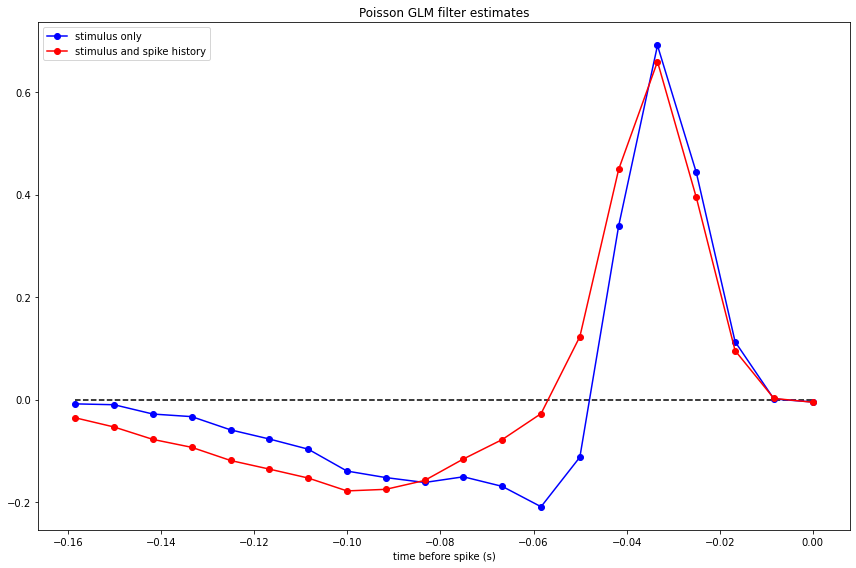

In [70]:
# 2b. Obtain filter from model with spike history

# Let's use the same number of parameters for spike history
nthist = 20

# Build spike-history design matrix
padded_spikes = np.hstack((np.zeros(nthist), spikes_train[:-1]))
design_mat_spikes = np.hstack((hankel(padded_spikes[:-nthist+1], padded_spikes[-nthist:]), np.ones((num_train_bins,1))))
design_mat_both = np.hstack((design_mat_stim[:,:-1], design_mat_spikes))

# Define training log-likelihood funcs
# I'm positioning the column of ones always at the end for convenience
loss_func = lambda prs : neglogli_poissGLM(prs, design_mat_both, spikes_train, dt_stim)

optimizer = minimize(fun=loss_func, x0=np.zeros(ntfilt+nthist+1), options={'disp':False})
wmap_both = optimizer.x[:ntfilt] # stimulus filter
sp_hist_filt = optimizer.x[ntfilt:-1] # spike history filter
const_both = optimizer.x[-1] # constant offset

# Let's plot the filters
ttk = np.arange(-ntfilt+1,1)*dt_stim
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)
ax1.plot(ttk,ttk*0, 'k--')
ax1.plot(ttk, wmap_stim/norm(wmap_stim), 'o-', c='b', label='stimulus only')
ax1.plot(ttk, wmap_both/norm(wmap_both), 'o-', c='r', label='stimulus and spike history')
ax1.set_title('Poisson GLM filter estimates')
ax1.set_xlabel('time before spike (s)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

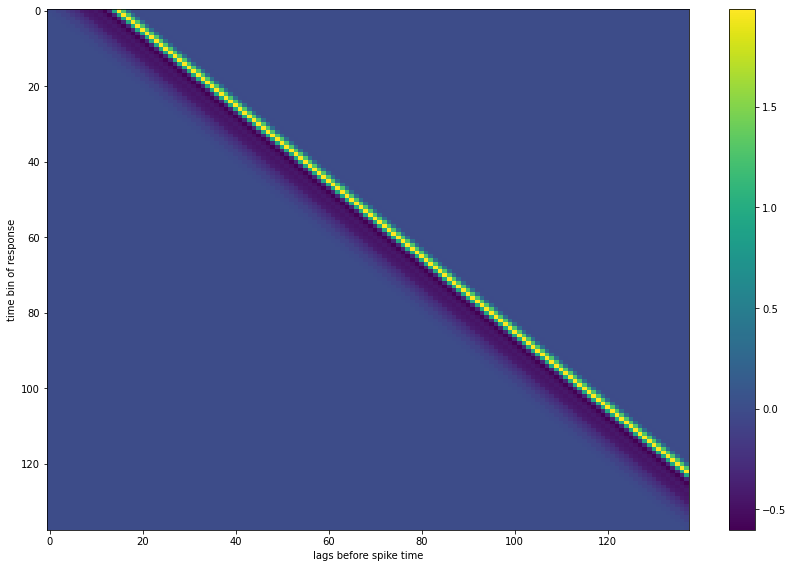

In [71]:
### ===== 3. Assemble model-based design matrices =======
# We will now use these filters to find the stimulus that maximizes
# the likelihood of held-out spikes, by constructing a design matrix
# out of the filters, and using the same minimize function but with
# the parameters representing the stimulus.

# We need to turn our filters into a design matrix where each row
# is a timepoint of stimulus we are fitting, such that the previous
# timepoints convolved with the filter produces a spike count. This means
# the matrix will essentially be passing the filter down the diagonal of
# a square matrix of with dimensions equal to how much stimulus we are predicting.
# This can be computed quickly as a toeplitz matrix.

pred_length = 100 # let's decode 100 frames of stimulus just as an example

# if you think about using 100 frames of stimulus to predict spikes
# the very first spike will actually be predictable using some stimulus
# before what we are fitting. Likewise, the last frame of stimulus
# is also useful in predicting the spike 19 (ntfilt-1) frames past
# our decoding window. For this reason, we need our desing matrix
# to be a little larger than 100 frames.
first_column = np.zeros((pred_length + 2*(ntfilt-1)))
first_column[0] = wmap_stim[0]
first_row = np.zeros((pred_length + 2*(ntfilt-1)))
first_row[:ntfilt] = wmap_stim
MAP_design_stim = toeplitz(first_column, first_row)

first_column = np.zeros((pred_length + 2*(ntfilt-1)))
first_column[0] = wmap_both[0]
first_row = np.zeros((pred_length + 2*(ntfilt-1)))
first_row[:ntfilt] = wmap_both
MAP_design_both = toeplitz(first_column, first_row)

# we can actually inspect the entire design matrix!
plt.clf()
plt.figure(figsize=[12,8])
plt.imshow(MAP_design_stim, aspect='auto', interpolation='nearest')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response')
plt.colorbar()
plt.tight_layout()
plt.show()

# Notice how projecting each row of the matrix onto a stimulus will predict
# the spike for that timepoint. Only the middle 100 frames correspond to the
# stimulus we are solving for.

In [72]:
### ==== 4. Collect testing data and precompute known spike info =====

# We will try to decode 100 frames of stimulus. However we also
# need the ntfilt-1 frames prior to it and ntfilt-1 frames following it
# to match our design matrix above.
pre_stim = stim[num_train_bins:num_train_bins + ntfilt-1]
stim_to_decode = stim[num_train_bins + ntfilt-1:num_train_bins + ntfilt-1 + pred_length]
post_stim = stim[num_train_bins + ntfilt-1 + pred_length:num_train_bins + 2*(ntfilt-1) + pred_length]

spikes_test = spikes_binned[num_train_bins:num_train_bins + pred_length + 2*(ntfilt-1)]

# Importantly, we are finding the stimulus that maximizes the likelihood of the spikes
# but we know that the models contain information about predicting spikes beyond
# just what the stimulus predicts. The constant offset should also be included in
# constructing the model's prediction. In the case of the model with spike history,
# we also should include what the spike history is predicting about the spikes.
# We can compute this info once and pass it into our log-likelihood function while optimizing.

known_spikes_stim = np.zeros(spikes_test.shape) + const_stim # known info about spikes from stim only model
known_spikes_both = np.zeros(spikes_test.shape) + const_both # known info about spikes from model with spike history

# we can compute what the spike history predicts in the same way we
# made log-likelihoods when finding the filter in the first place
padded_spikes = np.hstack((np.zeros(nthist), spikes_test[:-1]))
design_mat_spikes = hankel(padded_spikes[:-nthist+1], padded_spikes[-nthist:])
known_spikes_both += design_mat_spikes @ sp_hist_filt

In [73]:
### ==== 5a. Create new log-likelihood function ====

# We need a new version of this function, that allows us to take in
# frames of stimulus other than just the ones we are decoding
# for use in calculating log-likelihood. It also needs to take
# our precomputed non-stimulus predictions and add it to what
# the stimulus it is fitting predicts.

def neglogli_forMAP(thetas, xx, yy, dt_bin, known_info, pre_stim, post_stim):
    """ Compute negative log-likelihood of data under Poisson GLM model with
        exponential nonlinearity. Because we want to only upsample part of the design matrix
        This time we will not return gradient and hessian, for simplicity.
        
        Args
        ----
        thetas: ndarray  (d X 1)
            parameter vector
        xx: ndarray (T X d)
            design matrix
        yy: ndarray (T X 1)
            response variable (spike count per time bin)
        dt_bin: float
            time bin size used
        vals_to_return: int
            which of negative log-likelihood (0), gradient (1), or hessian (2) to return.
            3 returns all three values. This is necessary due to scipy.optimize.minimize
            requiring the three separate functions with a single return value for each.
        known_info: ndarray (T X 1)
            Information we already know about the yy variable.
        pre_stim: ndarray (ntfilt-1 X 1)
            The stimulus right before the block we are predicting.
        post_stim: ndarray (ntfilt-1 X 1)
            The stimulus right after the block we are predicting.
            
        Returns
        -------
        neglogli: float
            negative log likelihood of spike train
    """
    
    # Compute GLM filter output and conditional intensity
    # Combine thetas we are fitting with known stimulus
    thetas = np.concatenate((pre_stim, thetas, post_stim))
    vv = xx @ thetas # filter output
    
    vv += known_info # include what we already know about the spikes from the model
    rr = np.exp(vv) * dt_bin # conditional intensity (per bin)

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T @ yy; # spike term from Poisson log-likelihood
    Trm0 = np.sum(rr)  # non-spike term 
    neglogli = Trm1 + Trm0

    return neglogli

In [74]:
### ===== 5b. Create posterior function =====

# Now we come to a branching point. We have everything we need to decode the stimulus
# from the model, however we still need to incorporate the p(x), our prior over
# the stimulus. One option is to restrict it to be drawn from a a gaussian with
# the same variance as the stimulus we know. Another option is to use constrained
# optimization, where we find the optimal stimulus within a given set of boundaries.
# Here we will do both. So first we need a log posterior function.

def neglogposterior(thetas, neglogli_fun, Cinv):
    """ Compute negative log-posterior given a negative log-likelihood function
        and zero-mean Gaussian prior with inverse covariance 'Cinv'.
        
        # Compute negative log-posterior by adding quadratic penalty to log-likelihood
        
        Args
        ----
        thetas: ndarray (d X 1)
            parameter vector
        neglogli_fun: callable
            function that computes negative log-likelihood, gradient, and hessian.
        Cinv: ndarray (d X d)
            inverse covariance of prior
        
        Returns
        -------
        neglogpost: float
            negative log posterior
    """

    neglogpost = neglogli_fun(thetas)
    neglogpost = neglogpost + .5 * thetas.T @ Cinv @ thetas       
    
    return neglogpost

<Figure size 432x288 with 0 Axes>

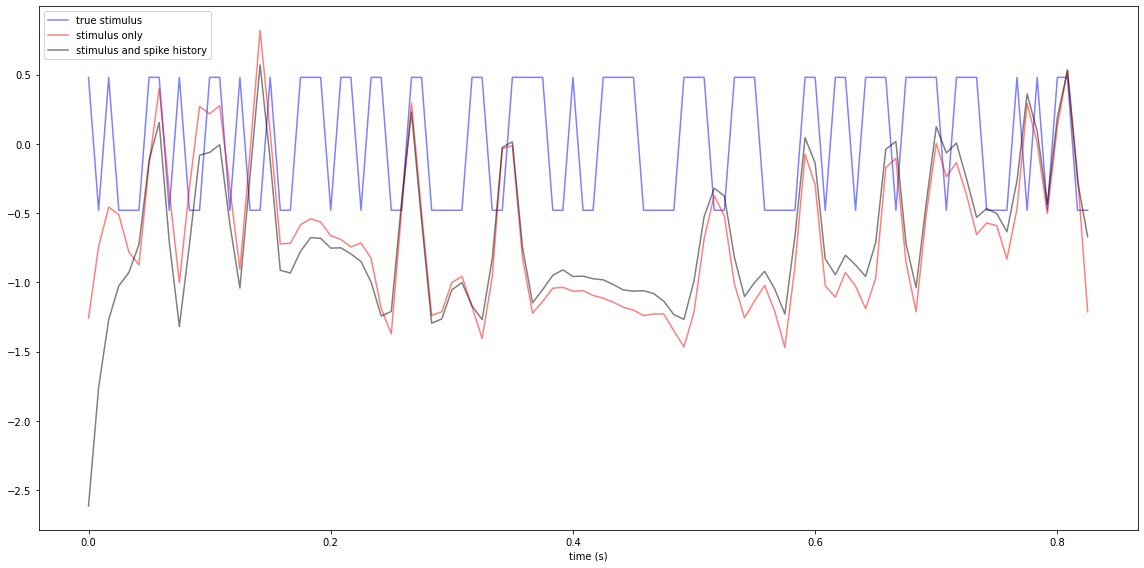

In [75]:
### ===== 5c. Run MAP estimation with gaussian prior =====

# First, lets create an inverse covariance matrix of our gaussian prior.
# this is equivalent to the L2 smoothing regularization from tutorial 4,
# where we choose a lambda to match the variance of the gaussian.

# only pred_length of stimulus are parameters being fit.
Dx1 = diags((np.ones((pred_length,1)) @ [[1,-1]]).T, np.arange(2), (pred_length-1, pred_length)).A
Dx = Dx1.T @ Dx1 # computes squared diffs
# Select smoothing penalty
lam = np.var(stim_train) # use variance of stimulus.
Cinv = lam*Dx # set inverse prior covariance

# create log likelihhod functions for each model.
neglogli_func_stim = lambda prs : neglogli_forMAP(prs, MAP_design_stim, spikes_test, dt_stim,
                                                  known_spikes_stim, pre_stim, post_stim)
neglogli_func_both = lambda prs : neglogli_forMAP(prs, MAP_design_both, spikes_test, dt_stim,
                                                  known_spikes_both, pre_stim, post_stim)

# create log posterior functions that are incorporating the prior
post_func_stim = lambda prs : neglogposterior(prs, neglogli_func_stim, Cinv)
post_func_both = lambda prs : neglogposterior(prs, neglogli_func_both, Cinv)

# Run the minimzations to identify optimal stimulus
optimizer_stim = minimize(fun=post_func_stim, x0=np.zeros(pred_length), tol=1e-6, options={'disp':False})
MAP_pred_stim = optimizer_stim.x
optimizer_both = minimize(fun=post_func_both, x0=np.zeros(pred_length), tol=1e-6, options={'disp':False})
MAP_pred_both = optimizer_both.x

# Plot true and decoded stimulus
plt.clf()
ttk = np.arange(pred_length)/120
plt.figure(figsize=[16,8])
plt.plot(ttk, stim_to_decode, c='b', alpha=.5, label='true stimulus')
plt.plot(ttk, MAP_pred_stim, c='r', alpha=.5, label='stimulus only')
plt.plot(ttk, MAP_pred_both, c='k', alpha=.5, label='stimulus and spike history')
plt.xlabel('time (s)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Notice the model overestimates and underestimates the stimulus a lot
# because we did not take into account something we know to be true
# of the stimulus, that it always is either -0.48 or +0.48.
# we can take this into account by using constrained optimization.

<Figure size 432x288 with 0 Axes>

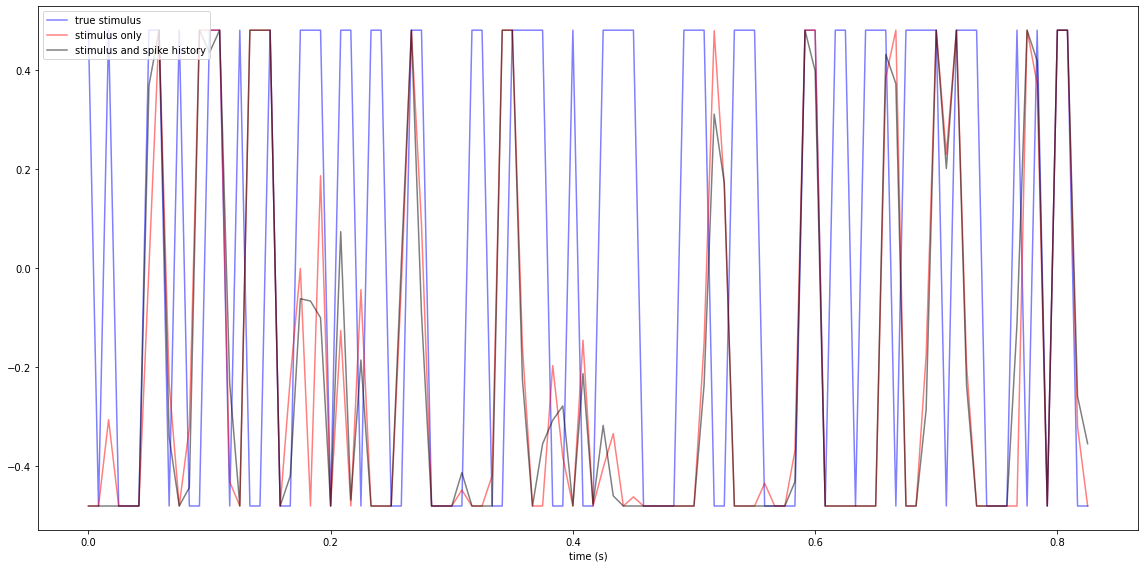

In [76]:
### ==== 6. Run MAP estimation with constrained optimization =====

# Now that we are forcing the minimizer to only sample parameter
# solutions within the given bounds, we no longer need to use
# our gaussian prior, so we will just be using the log likelihood
# function we wrote.

# create log likelihhod functions for each model.
neglogli_func_stim = lambda prs : neglogli_forMAP(prs, MAP_design_stim, spikes_test, dt_stim,
                                                  known_spikes_stim, pre_stim, post_stim)
neglogli_func_both = lambda prs : neglogli_forMAP(prs, MAP_design_both, spikes_test, dt_stim,
                                                  known_spikes_both, pre_stim, post_stim)

# Define the boundaries for our stimulus
bounds = Bounds(-0.48, 0.48, keep_feasible=True)

# Run the minimzations to identify optimal stimulus
optimizer_stim = minimize(fun=neglogli_func_stim, x0=np.zeros(pred_length),
                          tol=1e-6, options={'disp':False}, bounds=bounds)
MAP_pred_stim = optimizer_stim.x
optimizer_both = minimize(fun=neglogli_func_both, x0=np.zeros(pred_length),
                          tol=1e-6, options={'disp':False}, bounds=bounds)
MAP_pred_both = optimizer_both.x

# Plot true and decoded stimulus
plt.clf()
plt.figure(figsize=[16,8])
plt.plot(ttk, stim_to_decode, c='b', alpha=.5, label='true stimulus')
plt.plot(ttk, MAP_pred_stim, c='r', alpha=.5, label='stimulus only')
plt.plot(ttk, MAP_pred_both, c='k', alpha=.5, label='stimulus and spike history')
plt.xlabel('time (s)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# This looks much better

In [79]:
### ==== 7. Evaluate predictions using log SNR ====
from scipy.stats import pearsonr
# For now we will just compare the correlation coefficients.
# For a better measure of accuracy see log SNR from
# Pillow et al. 2008 (Nature, online methods)

# First we will compute the residuals of our predicted stimulus
corr_stim = pearsonr(stim_to_decode, MAP_pred_stim)[0]
corr_both = pearsonr(stim_to_decode, MAP_pred_both)[0]
print(f'Pearson R for model without spike history: {corr_stim}')
print(f'Pearson R for model with spike history: {corr_both}\n')
print('Not super interesting results without testing more blocks of stimulus')
print('And with this poor measure of accuracy!')

Pearson R for model without spike history: 0.13037463463176
Pearson R for model with spike history: 0.15962450878161358

Not super interesting results without testing more blocks of stimulus
And with this poor measure of accuracy!


 Advanced exercises:
 --------------------
 1. Write code that does full cross validation
 Perform 4-fold cross validation, training on 3/4 of the data in each fold,
 and then testing on every 100 frame block of stimulus in the held out 1/4.
 Implrement the log SNR estimate of mutual information from the online methods
 of [Pillow et al. 2008](http://pillowlab.princeton.edu/pubs/Pillow_etal_Nature08.pdf).

 2. Play around with different parameters
 Try adjusting the ntfilt and nthist size and see how that affects the decoding.
 Use other priors and cells to compare how the prior affects the performance.

 3. Consider spike history on a finer time resolution
 It is perhaps not surprising that there is not that much more information
 about the stimulus contained within the model that incorporates spike history,
 given that we are looking at large bin sizes and our data is the firing rate
 rather than the precise spike times. Adjust the code to use a bin size that
 can only possible contain single spikes, so that the spike history filter
 comes to reflect the influence of the precise spike timing. Information could be
 contained within the inter-spike-interval. Regularization will be important
 when first identifying the filter.
 
 4. Now try comparing models with coupling filters as well
 See tutorial 2 as well as [Pillow et al. 2008](http://pillowlab.princeton.edu/pubs/Pillow_etal_Nature08.pdf).